#### Import python files from another directory
In order to reuse code written in .py files you need to import them.
If they are from a distant folder, rather than copy-paste it into the current folder, you can write:

In [1]:
import sys

sys.path.append(
    "../../ex02/template"
)  # This goes up twice in the directories tree (hence in labs)
# then goes down to ex02/template where your files from lab 2 are.

you can now import your desired files, for example, we can import grid_search.py with:

In [2]:
from grid_search import *  # You can call any functions of the file with function_name()

# Let's try to call generate_w from grid_search.py:
w0, w1 = generate_w(5)
print(w0, w1)

[-100.  -25.   50.  125.  200.] [-150.  -75.    0.   75.  150.]


As you can see we are now able to call functions from the grid_search.py file.

In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import *

from test_utils import test

%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [4]:
def least_squares(y, tx):
    """Calculate the least squares solution.
       returns mse, and optimal weights.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
        mse: scalar.

    >>> least_squares(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]))
    (array([ 0.21212121, -0.12121212]), 8.666684749742561e-33)
    """
    # Optimal w* given rormal equations
    w = np.linalg.solve(tx.T@tx, tx.T@y)
    
    # Error vector
    e = y - tx @ w

    # Vectorised MSE
    mse = 1/(2*len(y)) * e.T @ e

    return w, mse

### You can test your implementation here

In [5]:
test(least_squares)
# NB:
#
# Due to precision issues,
# the output might not be exactly the same
# even if you have implemented the right code.
#
# For example, the mse output expected to be
# 8.666684749742561e-33,
# but you might get some other small number
# close to zero.
#
# In this case,
# Failing the test doesn't necessarily means
# your implementation is wrong.:)

✅ Your `least_squares` passed 1 tests.


### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [6]:
def test_your_least_squares():
    """
    # this code should compare the optimal weights obtained
    # by least squares vs. grid search
    """
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    # Run least squares
    w_least_square, mse = least_squares(y, tx)

    # Run grid search
    """
    grid_w0, grid_w1 = generate_w(num_intervals=50)
    grid_losses = grid_search(y, tx, grid_w0, grid_w1)
    loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
    w_grid_search = np.array([w0_star, w1_star])
    """

    print(f"Least Squares weights={w_least_square}, MSE={mse}")

Test it here

In [7]:
test_your_least_squares()

Least Squares weights=[73.293922   13.47971243], MSE=15.385887868829423


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [8]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [9]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        degree: integer.

    Returns:
        poly: numpy array of shape (N,d+1)

    >>> build_poly(np.array([0.0, 1.5]), 2)
    array([[1.  , 0.  , 0.  ],
           [1.  , 1.5 , 2.25]])
    """
    
    # Create augmented features by iterating over degrees
    augmented_features = np.hstack([(x**d).reshape(-1, 1) for d in range(0, degree+1)])

    return augmented_features

In [10]:
test(build_poly)

✅ Your `build_poly` passed 1 tests.


Once your implementation of `build_poly` passes the test, copy it to `build_polynomial.py`
Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [11]:
from plots import *


def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
    and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]

    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        # Build polynomial features
        xa = build_poly(x, degree=degree)
        
        # Compute optimal weights using least squares
        weights, mse = least_squares(y, xa)

        # Compute RMSE from least squares output
        rmse = np.sqrt(2 * mse)

        print(
            "Processing {i}th experiment, degree={d}, rmse={loss}".format(
                i=ind + 1, d=degree, loss=rmse
            )
        )
        # plot fit
        plot_fitted_curve(y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()

    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.4718760796342188
Processing 2th experiment, degree=3, rmse=0.2585827766773749
Processing 3th experiment, degree=7, rmse=0.24965870360907425
Processing 4th experiment, degree=12, rmse=0.2433978839453538


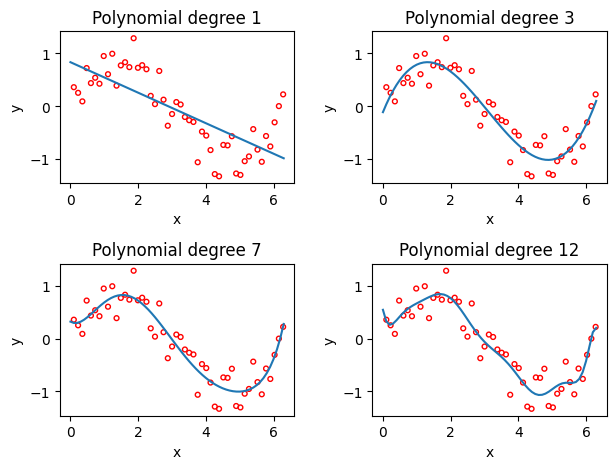

In [12]:
polynomial_regression()

Your results should look like this:

![alt text](visualize_polynomial_regression.png)

# 2 Evaluating model predication performance

Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [13]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8
    you will have 80% of your data set dedicated to training
    and the rest dedicated to testing. If ratio times the number of samples is not round
    you can use np.floor. Also check the documentation for np.random.permutation,
    it could be useful.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        y: numpy array of shape (N,).
        ratio: scalar in [0,1]
        seed: integer.

    Returns:
        x_tr: numpy array containing the train data.
        x_te: numpy array containing the test data.
        y_tr: numpy array containing the train labels.
        y_te: numpy array containing the test labels.

    >>> split_data(np.arange(13), np.arange(13), 0.8, 1)
    (array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]), array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]))
    """
    # Set seed
    np.random.seed(seed)

    # Get number of samples
    n = len(y)

    # Get index permutation for shuffled unbiased train/ test splits
    permuted_indices = np.random.permutation(np.arange(n))

    # Permute x, y using permuted indices
    x, y = x[permuted_indices], y[permuted_indices]

    # Split train and test split
    i = int(np.floor(n * ratio))
    x_tr, y_tr = x[:i], y[:i]
    x_te, y_te = x[i:], y[i:]

    return x_tr, x_te, y_tr, y_te

In [14]:
test(split_data)

✅ Your `split_data` passed 1 tests.


Then, test your `split_data` function below.

In [15]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees.

    Returns:
      x_tr: numpy array
      x_te: numpy array
      y_tr: numpy array
      y_te: numpy array
      weights: weights from the least squares optimization"""

    # Split data into train and test
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio)
    
    # Augment features for train and test split
    x_tra = build_poly(x_tr, degree)
    x_tea = build_poly(x_te, degree)

    # Compute optimal w from training set
    weights, _ = least_squares(y_tr, x_tra)

    # Anonymous function for RMSE
    rmse = lambda y, tx, w: np.sqrt(1/len(y) * np.sum(np.square(y - tx @ w)))

    # Compute RMSE for train and test data
    rmse_tr = rmse(y_tr, x_tra, weights)
    rmse_te = rmse(y_te, x_tea, weights)

    print(
        "proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
            p=ratio, d=degree, tr=rmse_tr, te=rmse_te
        )
    )

    return x_tr, x_te, y_tr, y_te, weights

Demo time

proportion=0.9, degree=1, Training RMSE=0.455, Testing RMSE=0.621
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.214
proportion=0.9, degree=7, Training RMSE=0.257, Testing RMSE=0.189
proportion=0.9, degree=12, Training RMSE=0.248, Testing RMSE=0.219
proportion=0.7, degree=1, Training RMSE=0.441, Testing RMSE=0.573
proportion=0.7, degree=3, Training RMSE=0.254, Testing RMSE=0.296
proportion=0.7, degree=7, Training RMSE=0.246, Testing RMSE=0.282
proportion=0.7, degree=12, Training RMSE=0.243, Testing RMSE=1.032
proportion=0.5, degree=1, Training RMSE=0.400, Testing RMSE=0.553
proportion=0.5, degree=3, Training RMSE=0.237, Testing RMSE=0.306
proportion=0.5, degree=7, Training RMSE=0.218, Testing RMSE=0.336
proportion=0.5, degree=12, Training RMSE=0.213, Testing RMSE=0.353
proportion=0.1, degree=1, Training RMSE=0.453, Testing RMSE=0.748
proportion=0.1, degree=3, Training RMSE=0.111, Testing RMSE=0.674
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=2.259
proport

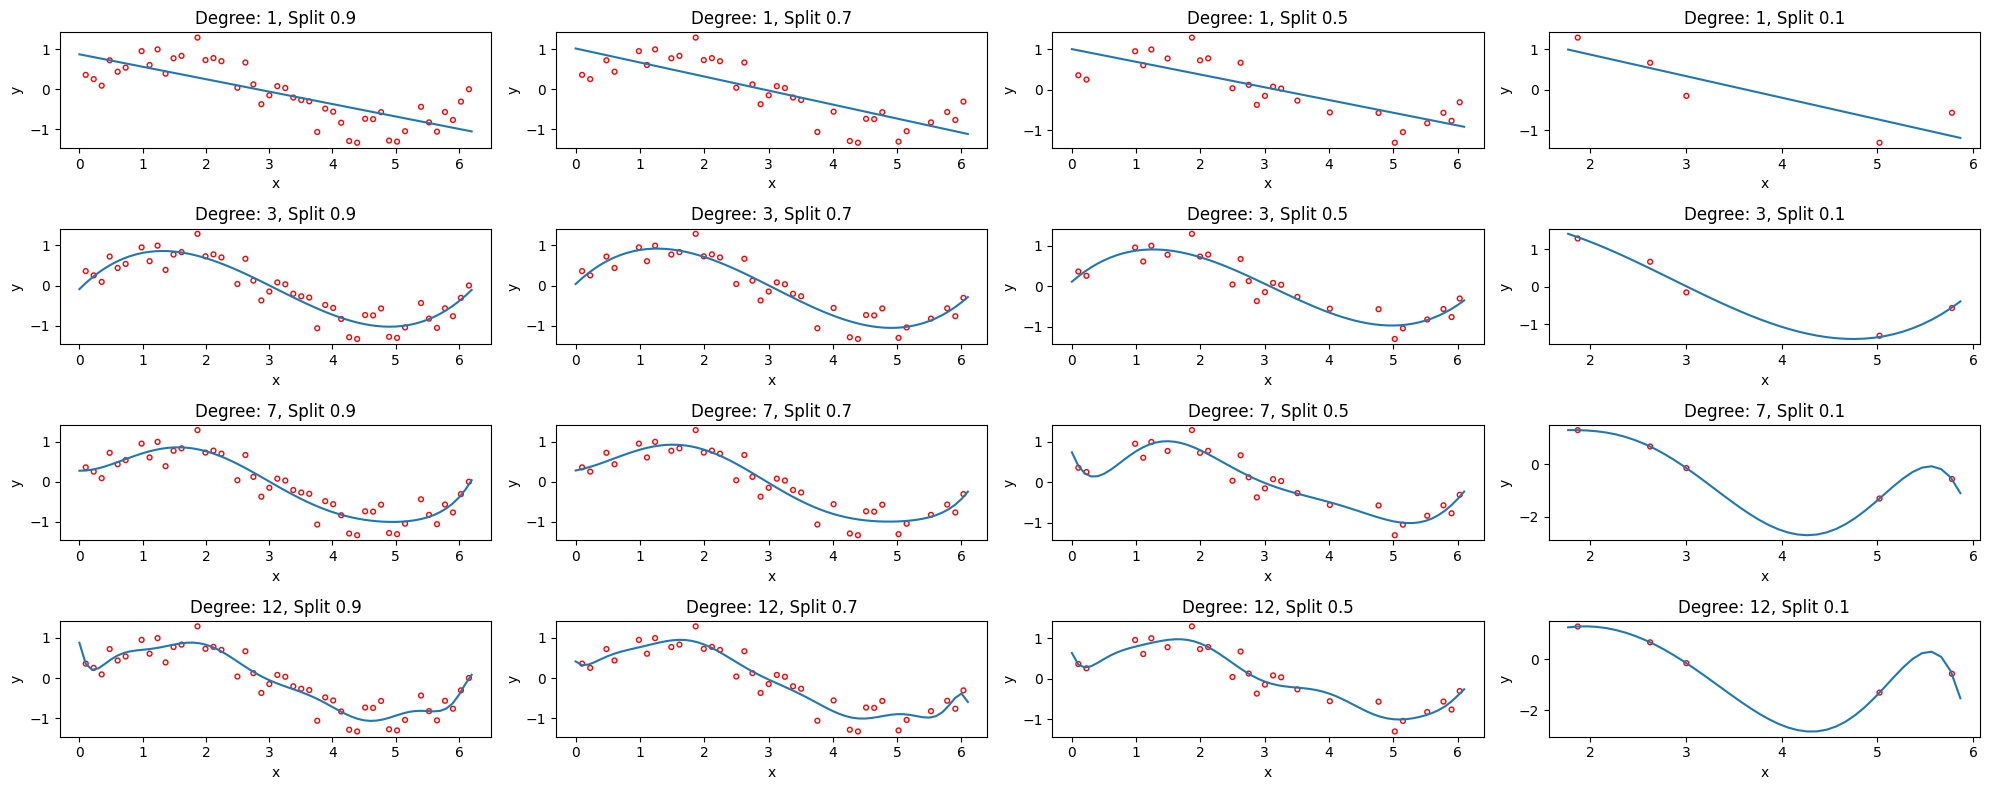

In [16]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.7, 0.5, 0.1]

# define the structure of the figure
num_row = 4
num_col = 4
axs = plt.subplots(num_row, num_col, figsize=(20, 8))[1]

for ind, split_ratio in enumerate(split_ratios):
    for ind_d, degree in enumerate(degrees):
        x_tr, x_te, y_tr, y_te, w = train_test_split_demo(
            x, y, degree, split_ratio, seed
        )
        plot_fitted_curve(y_tr, x_tr, w, degree, axs[ind_d][ind % num_col])
        axs[ind_d][ind].set_title(f"Degree: {degree}, Split {split_ratio}")
plt.tight_layout()

Your graph should look like this:

![alt text](split_demo.png)

# Ridge Regression
Please fill in the function below.

In [17]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.

    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 0)
    array([ 0.21212121, -0.12121212])
    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 1)
    array([0.03947092, 0.00319628])
    """
    n, d = tx.shape
    w = np.linalg.solve(tx.T@tx + 2*n*lambda_*np.eye(d), tx.T @ y)

    return w

In [18]:
test(ridge_regression)

✅ Your `ridge_regression` passed 2 tests.


In [19]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)

    # Split data into train and test
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio)

    # Build polynomial features
    x_tra = build_poly(x_tr, degree)
    x_tea = build_poly(x_te, degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # Compute optimal weight given ridge regression
        weights = ridge_regression(y_tr, x_tra, lambda_)

        # Anonymous function for RMSE
        rmse = lambda y, tx, w: np.sqrt(1/len(y) * np.sum(np.square(y - tx @ w)))

        # Compute RMSE for train and test data
        rmse_tr.append(rmse(y_tr, x_tra, weights))
        rmse_te.append(rmse(y_te, x_tea, weights))

        print(
            "proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]
            )
        )
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

Demo time

proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.220, Testing RMSE=0.319
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.222, Testing RMSE=0.319
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.225, Testing RMSE=0.322
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.226, Testing RMSE=0.325
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.327
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.329
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.329
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.229, Testing RMSE=0.327
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.229, Testing RMSE=0.319
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.232, Testing RMSE=0.302
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.239, Testing RMSE=0.279
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.259, Testing RMSE=0.266
proportion=0.5, degree=7, lambda=0.193, 

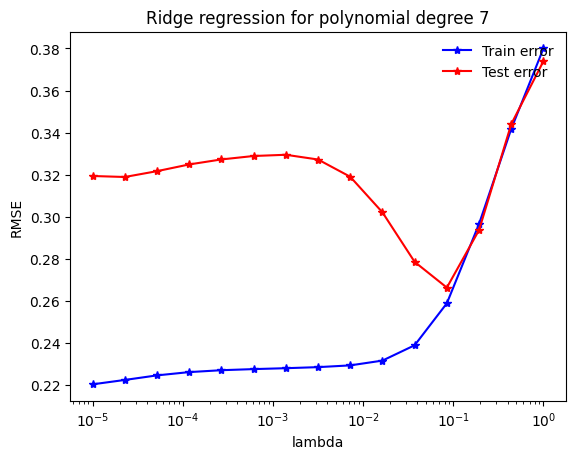

In [20]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)

Your plot should look like:

![alt text](ridge_regression.png)